In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [2]:

import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [3]:
import scipy
from scipy import io as sio
import h5py
from glob import glob

from torch import Value
def load_img(alpha=0.01, beta =0.02):
    try : 
        with h5py.File(f"/mnt/ssd/hyun/datasets/Fivek/test_fivek_rawRGB_alpha_{alpha}_beta_{beta}.hdf5",'r') as dataset:
            noisy = np.array(dataset['noisy_images'])
            clean = np.array(dataset['clean_images'])
            return noisy, clean
    except Exception as e:
        dataset_list = glob("/mnt/ssd/hyun/datasets/Fivek/test_fivek_rawRGB_alpha*.hdf5")
        l = []
        for dataset in dataset_list:
            target = dataset.split("_alpha_")[1]
            alpha,beta = target.split("_beta_")[0], target.split("_beta_")[1].split(".hdf5")[0]
            l.append([alpha,beta])
        print(e)
        raise ValueError("invalid noise parameter",alpha,beta,"Possible Fivek dataset alpha,sigma",l)
    
        

In [4]:
noisy_arr, clean_arr = load_img(0.01,0.02)
noisy_arr.shape

(200, 512, 512)

In [5]:

args = get_args()
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [17]:
!ls ../weights/230*fivek*

../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.0002_Noise_est_cropsize_200_vst_MAE.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.0002_Noise_est_cropsize_200_vst_MSE.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.0002_Noise_est_cropsize_200.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.02_Noise_est_cropsize_200_vst_MAE.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.02_Noise_est_cropsize_200_vst_MSE.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.01_beta_0.02_Noise_est_cropsize_200.w
../weights/230127_PGE_Net_RawRGB_fivek_alpha_0.05_beta_0.02_Noise_est_cropsize_200_vst_MSE.w
../weights/230202_FBI_Net_RawRGB_fivek_alpha_0.01_beta_0.02_EMSE_Affine_layers_x17_filters_x64_cropsize_200.w
../weights/230417_find_lambda_FBI_Net_RawRGB_fivek_alpha_0.01_beta_0.02_l1_on_img_gradient_1.0_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_220.w


In [16]:
import itertools
def get_fbi_weight(loss_fn = "MSE_Affine", filter_keyword = ['EMSE_Affine', 'Noise_est']):
    total_fbi_weight_list=  []
    fbi_weight_list = glob(f"../weights/230*_FBI_Net*fivek*MSE_Affine*")
    for keyword in filter_keyword:
        fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
    total_fbi_weight_list += sorted(list(fbi_weight_list))
    print(total_fbi_weight_list,'is loaded')
    return total_fbi_weight_list
target_fbi_weight = get_fbi_weight() 

['../weights/230417_find_lambda_FBI_Net_RawRGB_fivek_alpha_0.01_beta_0.02_l1_on_img_gradient_1.0_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_220.w'] is loaded


In [8]:
import math
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
def get_PSNR(X, X_hat):

    mse = np.mean((X-X_hat)**2)
    test_PSNR = 10 * math.log10(1/mse)
    
    return test_PSNR

def get_SSIM(X, X_hat):
    
    ch_axis = 0
    #test_SSIM = measure.compare_ssim(np.transpose(X, (1,2,0)), np.transpose(X_hat, (1,2,0)), data_range=X.max() - X.min(), multichannel=multichannel)
    test_SSIM = structural_similarity(X, X_hat, data_range=1.0, channel_axis=ch_axis)
    return test_SSIM

In [9]:
def parsing_weight_name(fbi_weight_dir):
    
    target = fbi_weight_dir.split("_alpha_")[1]
    alpha,beta = target.split("_beta_")[0], target.split("_beta_")[1].split("_")[0]
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("_l1_on_img_gradient_")[1].split("_")[0]
            
    else :
        lambda_val = 0
    
    loss_function_list = ['EMSE_Affine','MSE_Affine','MSE']
    for loss_f in loss_function_list:
        if loss_f in fbi_weight_dir:
            loss_function = loss_f
            if loss_f == 'MSE_Affine' and lambda_val != 0:
                loss_function += f'_with_tv_{lambda_val}'
            break
        
    return alpha,beta, loss_function

../weights/230417_find_lambda_FBI_Net_RawRGB_fivek_alpha_0.01_beta_0.02_l1_on_img_gradient_1.0_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_220.w
0 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


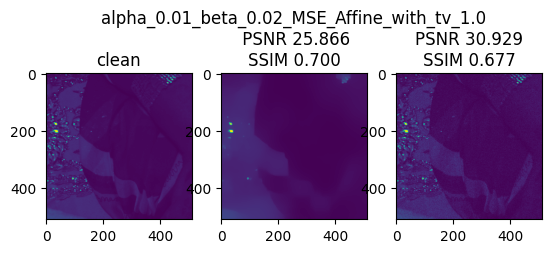

1 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


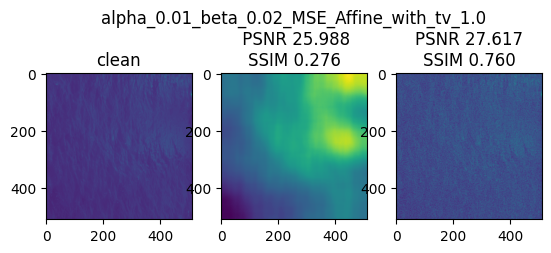

2 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


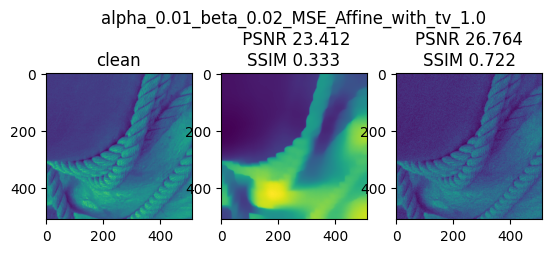

3 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


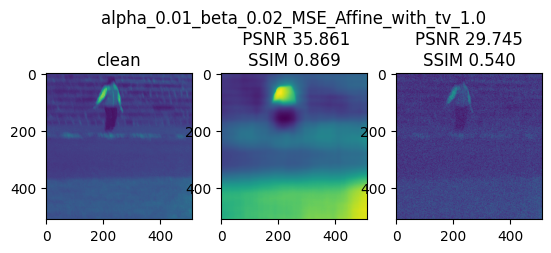

4 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


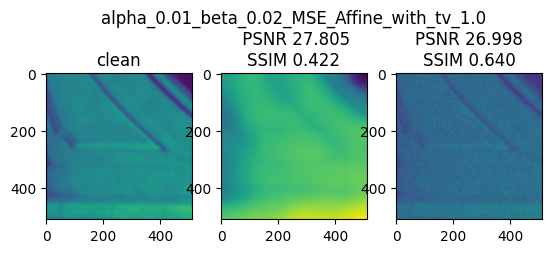

5 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


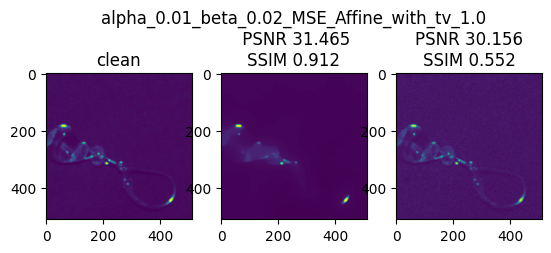

6 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


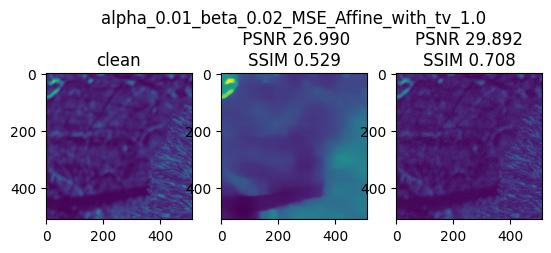

7 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


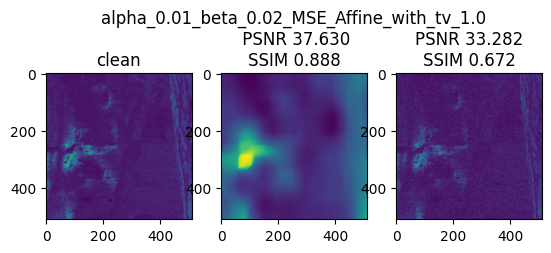

8 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


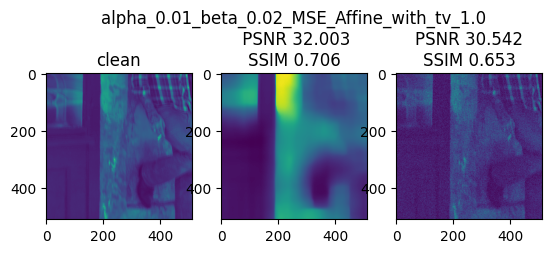

9 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


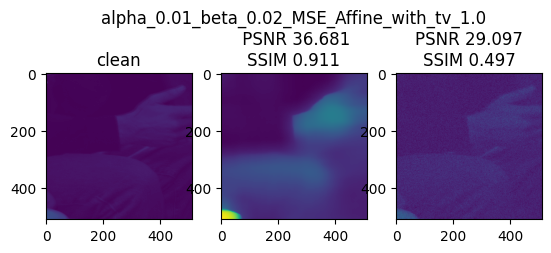

10 (512, 512) (512, 512)
alpha_0.01_beta_0.02_MSE_Affine_with_tv_1.0


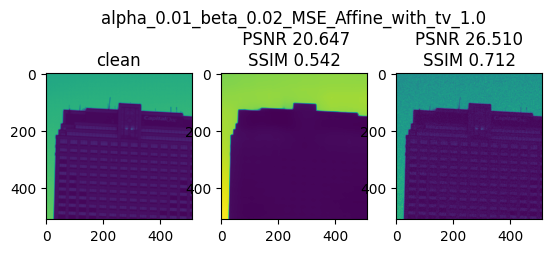

In [15]:

debug = True
metric = {}
for fbi_weight_dir in target_fbi_weight:

    alpha,beta, loss_function = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    key = f"alpha_{alpha}_beta_{beta}_{loss_function}"
    metric[key] = {}
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    metric[key] = {'PSNR':[],'SSIM':[],'before_PSNR':[],'before_SSIM':[]}
    # DENOISE IMAGE
    denoised_img_dict = {}
    for idx,(noisy_img, clean_img) in enumerate(zip(noisy_arr,clean_arr)):
        
        print(idx,noisy_img.shape, clean_img.shape)
        
        img = np.expand_dims(noisy_img,0)
        img = np.expand_dims(img,0)
        
        denoised_img = model.eval(img)[0][0]
        before_psnr, before_ssim = get_PSNR(clean_img,noisy_img),get_SSIM(clean_img,noisy_img)
        psnr,ssim = get_PSNR(clean_img,denoised_img),get_SSIM(clean_img,denoised_img)
        metric[key]['PSNR'].append(psnr)
        metric[key]['SSIM'].append(ssim)
        metric[key]['before_PSNR'].append(before_psnr)
        metric[key]['before_SSIM'].append(before_ssim)
        if debug is True:
            print(key)
            plt.subplot(131)
            plt.title("clean")
            plt.imshow(clean_img)
            
            plt.subplot(132)
            plt.title(f"{key}\n PSNR {psnr:.3f}\nSSIM {ssim:.3f}")
            plt.imshow(denoised_img)
            plt.subplot(133)
            plt.title(f"PSNR {before_psnr:.3f}\nSSIM {before_ssim:.3f}")
            plt.imshow(noisy_img)
            plt.pause(0.01)
        if idx >= 10 :
            break
            
        gc.collect()
    # np.save(f"./intermediate_result/{folder_name}_denoised_img_dict.npy",denoised_img_dict)
# np.save("PSNR/SSIM_metric.npy",metric)


In [5]:
def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("x_as_")[1][:3]
        print(target_x)
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    dataset_version = 'v1' if 'with_SET01020304' in fbi_weight_dir else 'v2'
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("l1_on_img_gradient_")[1].split("_")[0]
        dataset_version += f"_l1_on_img_gradient_{lambda_val}"
    return target_x,target_y, dataset_version